In [171]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import seaborn as sb
%pylab inline
import calendar
import datetime as dt

from pylab import rcParams
rcParams['figure.figsize'] = 20, 14

Populating the interactive namespace from numpy and matplotlib


# Читаем и преобразовываем JSON

In [163]:
with open('v8_20AA_2d3f.json', encoding='utf8') as data_file:
    json_data = json.load(data_file)

In [164]:
_columns=[val['Name']['#value'] for val in json_data['#value']['column']]#Вычленяем колонки
data=pd.DataFrame(data=json_data['#value']['row'], columns=_columns).apply(lambda row: [val['#value'] for val in row])#читаем JSON и вычленяем значения
data['Дата']=pd.to_datetime(data['Дата'],format='%Y-%m-%d')#преобразуем дату

del json_data


# Формируем новые характеристики

In [165]:
#параметры даты
data['Год']=data['Дата'].dt.year
data['Месяц']=data['Дата'].dt.month
data['Неделя']=data['Дата'].dt.week
data['День']=data['Дата'].dt.day
data['ДеньНедели']=data['Дата'].dt.weekday


#удаляем дату
data.drop('Дата', axis=1, inplace=True)

# 29 февраля: берем среднее за 28 и 29 февраля

In [185]:
condition29=(data['День'] > 28)&(data['Месяц']==2)
condition28=(data['День'] == 28)&(data['Месяц']==2)

def getCal(row):
    return dt.date(row['Год'], 2, 28).isocalendar()

#28 и 29 февраля  приравниваем к 28 февраля
data.ix[condition29,'День']=28
data.ix[condition28,'Неделя']=data.ix[condition28].apply(lambda row: getCal(row)[1], axis=1)
data.ix[condition28,'ДеньНедели']=data.ix[condition28].apply(lambda row: getCal(row)[2], axis=1)


#группируемые колонки
selectColumns=list(set(_columns)-set(['Дата','Количество'])|set(['Год','Месяц','День','Неделя','ДеньНедели']))

#среднее по 28 февраля
feb28=data[condition28].groupby(selectColumns)['Количество'].mean().reset_index()

#удаляем из оригинально датасета все 28 февраля
data.drop(data[condition28].index, inplace=True)

#добавляем среднее за 28 февраля
data=data.append(feb28)


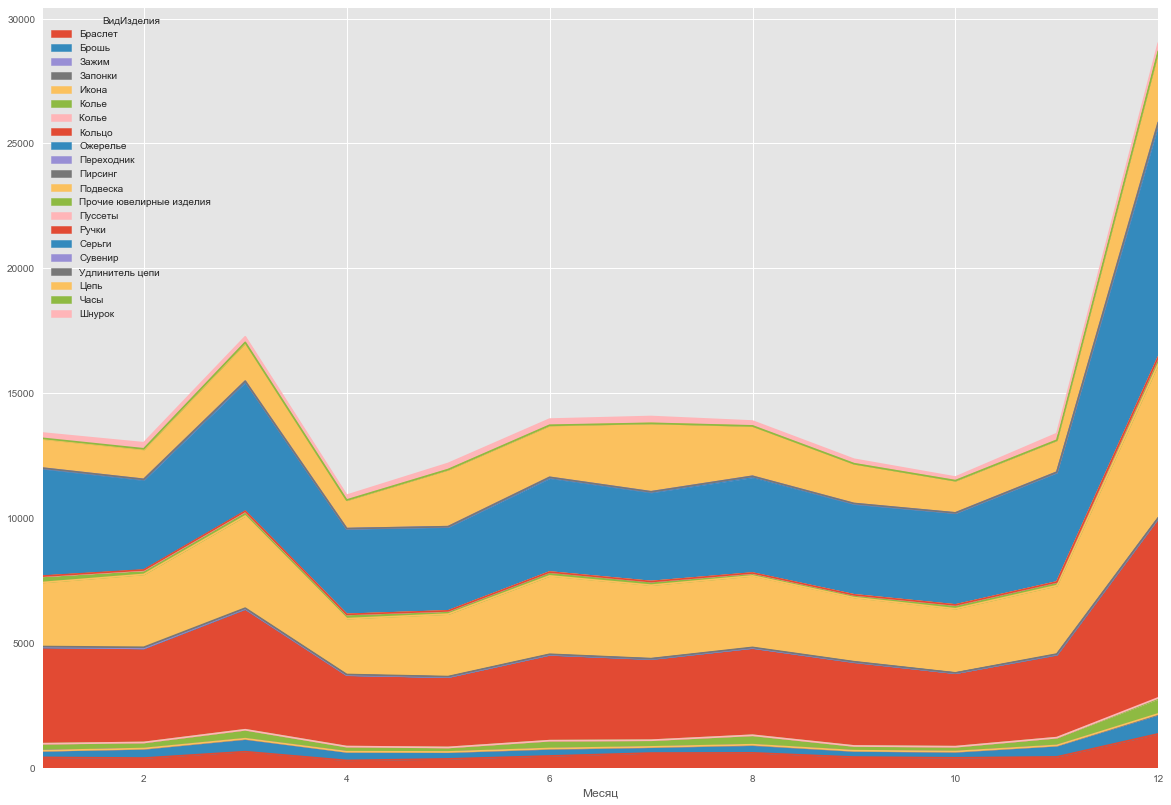

In [202]:
data[(data['Год']==2016)].pivot_table(index=['Месяц'], columns='ВидИзделия', values='Количество', aggfunc=sum,fill_value=0,dropna=False).plot(kind='area', legend=True,stacked=True)




